# 6.0002 Lecture 13: Classification

**Speaker:** Prof. John Guttag

In [1]:
import pylab, random

## Supervised Learning
- regression
    - predict a real number associated with a feature vector
    - e.g. use linear regression to fit a curve to data
- *classification*
    - predict a discrete value (label) associated with a feature vector

## Using distance matrix for classification
- simplest approach is probably **nearest neighbor**
- remember training data
- when predicting the label of a new example
    - find the nearest example in the training data
    - predict the label associated with that example

## K-nearest Neighbors
- take a number $k$ of nearest neigbhors to new data and then let them "vote"
    - label that dominates becomes predicted label of new data point

## Advantages and disadvantages of KNN
- advantages
    - learning fast, no explicit training
    - no theory required
    - easy to explain method and results
- disadvantages
    - memory intensive and predictions can take a long time
        - are better algorithms than brute force
    - no model to shed light on process that generated data

## The Titanic disaster
- RMS titanic sank in the North Atlantic the morning of 15 April 1912, after colliding with an iceberg. Of the 1300 passengers aboard, 812 died. (703 of the 918 crew members died.)
- database of 1046 passengers
    - cabin class
        - 1st, 2nd, or 3rd
    - age
    - gender

## Is accuracy enough
- if we just predict "died", accuracy will be >62% for passenger and >76% for crew members
- consider a disease that occurs in 0.1% of population
    - predicting disease-free has an accuracy of 0.999

## Other metrics
- how good is it at identifying positive (dead) cases:
$$\textrm{sensitivity} = \frac{\textrm{true positive}}{\textrm{true positive} + \textrm{true negative}}$$
- how specific is it:
$$\textrm{specificity} = \frac{\textrm{true negative}}{\textrm{true negative} + \textrm{false positive}}$$
- if we say somebody died, what's the probability that they really did:
$$\textrm{positive predictive value} = \frac{\textrm{true positive}}{\textrm{true positive} + \textrm{false positive}}$$
- if we say somebody didn't die, what's the probability that they really didn't:
$$\textrm{negative predictive value} = \frac{\textrm{true negative}}{\textrm{true negative} + \textrm{false positive}}$$
- note:
    - sensitivity = recall
    - specificity = precision

## Testing methodology matters
- leave-one-out
- repeated random subsampling

In [2]:
def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [3]:
class Passenger(object):
    featureNames = ('C1', 'C2', 'C3', 'age', 'male gender')
    def __init__(self, pClass, age, gender, survived, name):
        self.name = name
        self.featureVec = [0, 0, 0, age, gender]
        self.featureVec[pClass - 1] = 1
        self.label = survived
        self.cabinClass = pClass
    def distance(self, other):
        return minkowskiDist(self.featureVec, other.featureVec, 2)
    def getClass(self):
        return self.cabinClass
    def getAge(self):
        return self.featureVec[3]
    def getGender(self):
        return self.featureVec[4]
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.featureVec[:]
    def getLabel(self):
        return self.label
        
def getTitanicData(fname):
    data = {}
    data['class'], data['survived'], data['age'] = [], [], []
    data['gender'], data['name'] = [], []
    f = open(fname)
    line = f.readline()
    while line != '':
        split = line.split(',')
        data['class'].append(int(split[0]))
        data['age'].append(float(split[1]))
        if split[2] == 'M':
            data['gender'].append(1)
        else:
            data['gender'].append(0)
        if split[3] == '1':
            data['survived'].append('Survived')
        else:
            data['survived'].append('Died')
        data['name'].append(split[4:])
        line = f.readline()
    return data

In [4]:
def buildTitanicExamples(fileName):
    data = getTitanicData(fileName)
    examples = []
    for i in range(len(data['class'])):
        p = Passenger(data['class'][i], data['age'][i],
                      data['gender'][i], data['survived'][i],
                      data['name'][i])
        examples.append(p)
    print('Finishe processing', len(examples), 'passengers\n')    
    return examples
    
examples = buildTitanicExamples('TitanicPassengers.txt')

Finishe processing 1046 passengers



In [5]:
# nearest neighbor
def findNearest(name, exampleSet, metric):
    for e in exampleSet:
        if e.getName() == name:
            example = e
            break
    curDist = None
    for e in exampleSet:
        if e.getName() != name:
            if curDist == None or\
               metric(example, e) < curDist:
                nearest = e
                curDist = metric(example, nearest)
    return nearest

## Helper code

In [6]:
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg
    denominator = truePos + trueNeg + falsePos + falseNeg
    return numerator/denominator

In [7]:
# other metrics
def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')
    
def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')
    
def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')

In [8]:
def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print(' Accuracy =', round(accur, 3))
        print(' Sensitivity =', round(sens, 3))
        print(' Specificity =', round(spec, 3))
        print(' Pos. Pred. Val. =', round(ppv, 3))
    return (accur, sens, spec, ppv)

## Leave-one-out

In [9]:
def leaveOneOut(examples, method, toPrint=True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(examples)):
        testCase = examples[i]
        trainingData = examples[0:i] + examples[i+1:]
        results = method(trainingData, [testCase])
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    if toPrint:
        getStats(truePos, falsePos, trueNeg, falseNeg)
    return truePos, falsePos, trueNeg, falseNeg

## Repeated random subsampling

In [10]:
def split80_20(examples):
    sampleIndices = random.sample(range(len(examples)), len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

In [15]:
def randomSplits(examples, method, numSplits, toPrint=True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    random.seed(0)
    for t in range(numSplits):
        trainingSet, testSet = split80_20(examples)
        results = method(trainingSet, testSet)
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    getStats(truePos/numSplits, falsePos/numSplits,
             trueNeg/numSplits, falseNeg/numSplits, toPrint)
    return truePos/numSplits, falsePos/numSplits, trueNeg/numSplits, falseNeg/numSplits

## Let's try KNN

In [16]:
def findKNearest(example, exampleSet, k):
    kNearest, distances = [], []
    #Build lists containing first k examples and their distances
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.distance(exampleSet[i]))
    maxDist = max(distances) #Get maximum distance
    #Look at examples not yet considered
    for e in exampleSet[k:]:
        dist = example.distance(e)
        if dist < maxDist:
            #replace farther neighbor by this one
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)      
    return kNearest, distances

In [17]:
def KNearestClassify(training, testSet, label, k):
    """Assumes training & testSet lists of examples, k an int
       Predicts whether each example in testSet has label
       Returns number of true positives, false positives,
          true negatives, and false negatives"""
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for testCase in testSet:
        nearest, distances = findKNearest(testCase, training, k)
        #conduct vote
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: #guess label
            if testCase.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: #guess not label
            if testCase.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

## Results

In [18]:
knn = lambda training, testSet: KNearestClassify(training, testSet, 'Survived', 3)
numSplits = 10
print('Average of', numSplits, '80/20 splits using KNN (k=3)')
truePos, falsePos, trueNeg, falseNeg = randomSplits(examples, knn, numSplits)

print('Average of LOO testing using KNN (k=3)')
truePos, falsePos, trueNeg, falseNeg = leaveOneOut(examples, knn)

Average of 10 80/20 splits using KNN (k=3)
 Accuracy = 0.766
 Sensitivity = 0.67
 Specificity = 0.836
 Pos. Pred. Val. = 0.747
Average of LOO testing using KNN (k=3)
 Accuracy = 0.769
 Sensitivity = 0.663
 Specificity = 0.842
 Pos. Pred. Val. = 0.743


- considerably better than 62%
- not much difference between experiments

## Logistic Regression
- analogous to linear regression
- designed explicitly for predicting **probability** of an event
    - dependent variable can only take on a finite set of values
        - usually 0 or 1
- finds **weights** for each feature
    - positive implies variable positively correlated with outcome
    - negative implies variable negatively correlated with outcome
    - absolute magnitude related to strength of correlation
- optimization problem is a bit complex, key is use of a log function

## class LogisticRegression

In [19]:
import sklearn.linear_model

- fit(sequence of feature vectors, sequence of labels)
    - returns object of type LogisticRegression
- coef_
    - returns weights of features
- predict_proba
    - returns probabilities of labels

## building a model

In [20]:
def buildModel(examples, toPrint=True):
    featureVecs, labels = [], []
    for e in examples:
        featureVecs.append(e.getFeatures())
        labels.append(e.getLabel())
    LogisticRegression = sklearn.linear_model.LogisticRegression
    model = LogisticRegression().fit(featureVecs, labels)
    if toPrint:
        print('model.classes_ =', model.classes_)
        for i in range(len(model.coef_)):
            print('For label', model.classes_[1])
            for j in range(len(model.coef_[0])):
                print('   ', Passenger.featureNames[j], '=',
                      model.coef_[0][j])
    return model

## applying model

In [21]:
def applyModel(model, testSet, label, prob=0.5):
    testFeatureVecs = [e.getFeatures() for e in testSet]
    probs = model.predict_proba(testFeatureVecs)
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(probs)):
        if probs[i][1] > prob:
            if testSet[i].getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else:
            if testSet[i].getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg

## Python aside: List comprehension
- expr for id in L
- creates a list by evaluating expr len(L) times with id in expr replaced by each element of L

In [22]:
L = [x*x for x in range(10)]
print(L)

L = [x*x for x in range(10) if x%2 == 0]
print(L)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 4, 16, 36, 64]


## Putting it together

In [26]:
def lr(trainingData, testData, prob=0.5):
    model = buildModel(trainingData, False)
    results = applyModel(model, testData, 'Survived', prob)
    return results

## Results

In [27]:
# test logistic regression (LR)
numSplits = 10
print('Average of', numSplits, '80/20 splits LR')
truePos, falsePos, trueNeg, falseNeg = randomSplits(examples, lr, numSplits)

print('Average of LOO testing using LR')
truePos, falsePos, trueNeg, falseNeg = leaveOneOut(examples, lr)

Average of 10 80/20 splits LR
 Accuracy = 0.77
 Sensitivity = 0.697
 Specificity = 0.823
 Pos. Pred. Val. = 0.74
Average of LOO testing using LR
 Accuracy = 0.785
 Sensitivity = 0.705
 Specificity = 0.84
 Pos. Pred. Val. = 0.752


## Compare to KNN results
- performance not much different
- logistic regression slightly better
- also provides insight about variables

## Looking at Feature weights

In [28]:
buildModel(examples, True)

model.classes_ = ['Died' 'Survived']
For label Survived
    C1 = 1.1493657210845625
    C2 = -0.08358519917707398
    C3 = -1.0656512028060414
    age = -0.033432942840003047
    male gender = -2.423435165039198


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

- first class (C1) passengers more likely to survive
- age is negatively correlated
    - the older passenger is, less likely they are to survive
- being male is very negatively correlated

## Changing the cutoff

In [29]:
random.seed(0)

trainingSet, testSet = split80_20(examples)
model = buildModel(trainingSet, False)
print('Try p = 0.1')
truePos, falsePos, trueNeg, falseNeg =\
                   applyModel(model, testSet, 'Survived', 0.1)
getStats(truePos, falsePos, trueNeg, falseNeg)

print('Try p = 0.9')
truePos, falsePos, trueNeg, falseNeg =\
                   applyModel(model, testSet, 'Survived', 0.9)
getStats(truePos, falsePos, trueNeg, falseNeg)

Try p = 0.1
 Accuracy = 0.493
 Sensitivity = 0.976
 Specificity = 0.161
 Pos. Pred. Val. = 0.444
Try p = 0.9
 Accuracy = 0.66
 Sensitivity = 0.188
 Specificity = 0.984
 Pos. Pred. Val. = 0.889


(0.6602870813397129,
 0.18823529411764706,
 0.9838709677419355,
 0.8888888888888888)

## Receiver Operating Characteristic (ROC)

In [34]:
def buildROC(trainingSet, testSet, title, plot=True):
    model = buildModel(trainingSet, True)
    xVals, yVals = [], []
    p = 0.0
    while p <= 1.0:
        truePos, falsePos, trueNeg, falseNeg =\
                               applyModel(model, testSet,
                               'Survived', p)
        xVals.append(1.0 - specificity(trueNeg, falsePos))
        yVals.append(sensitivity(truePos, falseNeg))
        p += 0.01
    auroc = sklearn.metrics.auc(xVals, yVals)
    if plot:
        pylab.plot(xVals, yVals)
        pylab.plot([0,1], [0,1])
        title = title + '\nAUROC = ' + str(round(auroc,3))
        pylab.title(title)
        pylab.xlabel('1 - specificity')
        pylab.ylabel('Sensitivity')
    return auroc

In [35]:
#set line width
pylab.rcParams['lines.linewidth'] = 4
#set font size for titles 
pylab.rcParams['axes.titlesize'] = 20
#set font size for labels on axes
pylab.rcParams['axes.labelsize'] = 20
#set size of numbers on x-axis
pylab.rcParams['xtick.labelsize'] = 16
#set size of numbers on y-axis
pylab.rcParams['ytick.labelsize'] = 16
#set size of ticks on x-axis
pylab.rcParams['xtick.major.size'] = 7
#set size of ticks on y-axis
pylab.rcParams['ytick.major.size'] = 7
#set size of markers
pylab.rcParams['lines.markersize'] = 10
#set number of examples shown in legends
pylab.rcParams['legend.numpoints'] = 1

model.classes_ = ['Died' 'Survived']
For label Survived
    C1 = 1.2864157435170809
    C2 = -0.20872070112571148
    C3 = -1.0778841072853356
    age = -0.0393718540430409
    male gender = -2.304054249956562


0.860056925996205

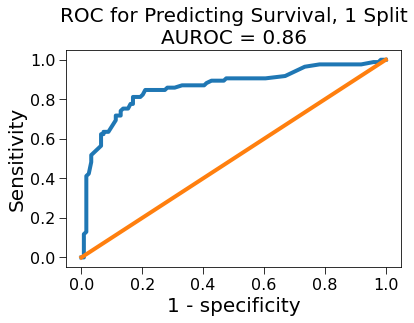

In [36]:
random.seed(0)
trainingSet, testSet = split80_20(examples)
buildROC(trainingSet, testSet, 'ROC for Predicting Survival, 1 Split')